In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import cvxpy as cp

sns.set_style("whitegrid")

In [43]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  file_name = list(uploaded.keys())[0]

#Do Benchmarku mWIG
uploaded_df_mwig = files.upload()

for fn in uploaded_df_mwig.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_df_mwig[fn])))

  file_name_df_mwig = list(uploaded_df_mwig.keys())[0]
df_mwig = pd.read_csv(file_name_df_mwig, dtype=str)

#Do Benchmarku sWIG
uploaded_df_swig = files.upload()

for fn in uploaded_df_swig.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_df_swig[fn])))

  file_name_df_swig = list(uploaded_df_swig.keys())[0]
df_swig = pd.read_csv(file_name_df_swig, dtype=str)

#portfolio2
uploaded_portfolio2 = files.upload()

for fn in uploaded_portfolio2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_portfolio2[fn])))

  file_name_portfolio2 = list(uploaded_portfolio2.keys())[0]
df_pf = pd.read_excel(file_name_portfolio2, dtype=str)

Saving portfolio (1).xlsx to portfolio (1) (4).xlsx
User uploaded file "portfolio (1) (4).xlsx" with length 87559 bytes


Saving mwig40tr_d (1).csv to mwig40tr_d (1) (6).csv
User uploaded file "mwig40tr_d (1) (6).csv" with length 185150 bytes


Saving swig80tr_d (1).csv to swig80tr_d (1) (5).csv
User uploaded file "swig80tr_d (1) (5).csv" with length 199073 bytes


Saving portfolio2.xlsx to portfolio2 (2).xlsx
User uploaded file "portfolio2 (2).xlsx" with length 11761 bytes


In [16]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import yfinance as yf

# Ustawienie dat
end_date = datetime.today()
three_years_ago = end_date - relativedelta(years=3)

# Dni robocze
business_days = pd.date_range(start=three_years_ago, end=end_date, freq='B')
start_date = business_days[0]

# Konwersja dat do tz-naive
start_date = pd.Timestamp(start_date).tz_localize(None)
end_date = pd.Timestamp(end_date).tz_localize(None)

print(f"Start date: {start_date.date()}")
print(f"End date: {end_date.date()}")



Start date: 2022-04-14
End date: 2025-04-14


## Portfel (korzystamy z pliku portolfio - transakcje)

In [9]:
# Czytamy dane z pliku z trasakcjami
#file_path = "/Users/korneliakozaczewska/Desktop/portfolio.xlsx"
#df_tx = pd.read_excel(file_path, dtype=str)
#print(df_tx.head(10))
df_tx = pd.read_excel(file_name, dtype=str)

# Czytamy kolumny z pliku
if "Liczba akcji" in df_tx.columns:
    df_tx["Liczba akcji"] = df_tx["Liczba akcji"].str.replace(",", ".")
    df_tx["Liczba akcji"] = pd.to_numeric(df_tx["Liczba akcji"])
else:
    print("Brak Liczba akcji")

if "Ticker" in df_tx.columns:
    df_tx["Ticker"] = (
        df_tx["Ticker"]
        .astype(str)
        .apply(lambda x: x.replace("WSE:", "") + ".WA" if x else x)
    )
else:
    print("Brak Ticker")

if "Data zrealizowania transakcji" in df_tx.columns:
    df_tx["Data"] = pd.to_datetime(df_tx["Data zrealizowania transakcji"], dayfirst=True, errors="coerce")
    df_tx = df_tx.sort_values("Data")
else:
    print("Brak Data")

if "Wartość kupna/sprzedaży" in df_tx.columns:
    df_tx["Wartość kupna/sprzedaży"] = (df_tx["Wartość kupna/sprzedaży"].str.replace(",", "."))
    df_tx["Wartość kupna/sprzedaży"] = pd.to_numeric(df_tx["Wartość kupna/sprzedaży"])
else:
    print("Brak Wartość kupna/sprzedaży")

if "Czynność" in df_tx.columns:
    df_tx["Czynność"] = df_tx["Czynność"].astype(str).str.strip()
else:
    print("Brak Czynność")

if "Wpłacona kwota" in df_tx.columns:
    df_tx["Wpłacona kwota"] = (df_tx["Wpłacona kwota"].str.replace(",", "."))
    df_tx["Wpłacona kwota"] = pd.to_numeric(df_tx["Wpłacona kwota"])
else:
    print("Brak Wpłacona kwota")

# Obliczamy gotówkę na podstawie wpłat + wartość transakcji sprzedazy - wartość transakcji kupna
cash = df_tx["Wpłacona kwota"].sum()
buy_spent = df_tx.loc[df_tx["Czynność"] == "BUY", "Wartość kupna/sprzedaży"].sum()
sell_income = df_tx.loc[df_tx["Czynność"] == "SELL", "Wartość kupna/sprzedaży"].sum()
current_cash = cash + sell_income - buy_spent

# Pokazujemy te kwoty + aktualny stan gotówki
print(f"\nTransakcje BUY: {buy_spent:.2f} PLN")
print(f"Transakcje SELL: {sell_income:.2f} PLN")
print(f"Aktualny stan gotówki (po transakcjach): {current_cash:.2f} PLN")

# Dla transakcji sell dajemy liczbę akcji z minusem
df_tx["Liczba akcji"] = df_tx.apply(
    lambda row: row["Liczba akcji"] if row["Czynność"] == "BUY"
                else -row["Liczba akcji"] if row["Czynność"] == "SELL"
                else 0,
    axis=1
)

# Sumujemy liczbę akcji po tickerach
df_positions = df_tx.groupby("Ticker")["Liczba akcji"].sum()
df_positions = df_positions.drop("nan.WA", errors="ignore")

#print("\nLiczba akcji netto (BUY - SELL) po transakcjach:")
#print(df_positions)

# "Spisujemy" posiadane tickery
tickers = df_positions.index.tolist()

# Ściągamy ceny zamknięcia posiadanych tickerów z yahoo finance dla podanego zakresu dat
price_data = yf.download(tickers, start=start_date, end=end_date)["Close"]
last_prices = price_data.iloc[-1] # Ostatnie ceny zamknięcia

# Spisujemy sobie dane do nowej ramki i obliczamy wartość posiadanych akcji
df_portfolio = pd.DataFrame(df_positions, columns=["Liczba akcji"])
df_portfolio["Liczba akcji"] = pd.to_numeric(df_portfolio["Liczba akcji"], errors="coerce").fillna(0)
df_portfolio["Ostatnia cena"] = df_portfolio.index.map(last_prices).fillna(0)
df_portfolio["Ostatnia cena"] = pd.to_numeric(df_portfolio["Ostatnia cena"], errors="coerce").fillna(0)
df_portfolio["Wartość"] = df_portfolio["Liczba akcji"] * df_portfolio["Ostatnia cena"]

#print(df_portfolio)

# Dodajemy gotówkę do portfolio
df_portfolio.loc["GOTÓWKA", "Liczba akcji"] = np.nan
df_portfolio.loc["GOTÓWKA", "Ostatnia cena"] = np.nan
df_portfolio.loc["GOTÓWKA", "Wartość"] = current_cash

# Liczymy udział spółek/gotówki w portfelu
total_value = df_portfolio["Wartość"].sum()
if total_value != 0:
    df_portfolio["Udział %"] = (df_portfolio["Wartość"] / total_value) * 100
else:
    df_portfolio["Udział %"] = 0

# Pokazujemy całkowitą wartość portfela
print("\nPortfel - udział poszczególnych spółek (z uwzględnieniem gotówki i transakcji BUY/SELL):")
display(df_portfolio)
print(f"\nCałkowita wartość portfela: {total_value:.2f} PLN")

<ipython-input-9-e06e78625491>:24: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df_tx["Data"] = pd.to_datetime(df_tx["Data zrealizowania transakcji"], dayfirst=True, errors="coerce")



Transakcje BUY: 90000.00 PLN
Transakcje SELL: 0.00 PLN
Aktualny stan gotówki (po transakcjach): 10000.00 PLN
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  9 of 9 completed


Portfel - udział poszczególnych spółek (z uwzględnieniem gotówki i transakcji BUY/SELL):


Liczba akcji  Ostatnia cena       Wartość   Udział %
Ticker                                                       
AMB.WA         440.53      21.500000   9471.395000   9.832627
ANR.WA         413.22      27.750000  11466.855000  11.904193
BFT.WA           3.43    2800.000000   9604.000000   9.970290
DOM.WA          50.51     204.000000  10304.040000  10.697029
NEU.WA          12.17     673.000000   8190.410000   8.502786
TXT.WA         168.63      50.150002   8456.794757   8.779331
VOX.WA          73.53     135.199997   9941.255776  10.320408
VRC.WA          84.39     108.199997   9130.997742   9.479247
WTN.WA         489.00      19.959999   9760.439552  10.132696
GOTÓWKA           NaN            NaN  10000.000000  10.381393


Całkowita wartość portfela: 96326.19 PLN


## Dywidendy i splity

In [17]:
df_close = price_data.copy()
df_close.index = pd.to_datetime(df_close.index)
df_close.index = df_close.index.tz_localize(None)
df_close_date = df_close

# Dywidendy
df_div = pd.DataFrame()
for ticker in tickers:
    div_series = yf.Ticker(ticker).dividends
    div_series.index = div_series.index.tz_localize(None)  # <-- KLUCZOWE
    series = div_series.loc[start_date:end_date]
    df_div = pd.concat([df_div, series], axis=1)
df_div.columns = tickers
df_div.index = pd.to_datetime(df_div.index)
df_div.index = df_div.index.tz_localize(None)
df_div_date = df_div.reindex(df_close.index, fill_value=0)

# Splity
df_splits = pd.DataFrame()
for ticker in tickers:
    split_series = yf.Ticker(ticker).splits
    split_series.index = split_series.index.tz_localize(None)  # <-- KLUCZOWE
    series = split_series.loc[start_date:end_date]
    df_splits = pd.concat([df_splits, series], axis=1)
df_splits.columns = tickers
df_splits.index = pd.to_datetime(df_splits.index)
df_splits.index = df_splits.index.tz_localize(None)
df_splits_date = df_splits.reindex(df_close.index, fill_value=0)

# Skorygowane ceny (adjusted close)
df_adj_close = df_close_date.copy()
for ticker in df_close_date.columns:
    factor = pd.Series(1.0, index=df_close_date.index)
    for i in range(1, len(df_close_date)):
        date = df_close_date.index[i]
        prev_date = df_close_date.index[i-1]

        # Dywidendy
        div = df_div_date.loc[date, ticker] if ticker in df_div_date.columns else 0
        day_factor_div = 1.0
        if pd.notna(div) and div != 0:
            price_before = df_close_date.loc[prev_date, ticker]
            day_factor_div = 1.0 - (div / price_before)

        # Splity
        split = df_splits_date.loc[date, ticker] if ticker in df_splits_date.columns else np.nan
        day_factor_split = 1.0
        if pd.notna(split) and split != 0:
            day_factor_split = 1.0 / split

        day_factor = day_factor_div * day_factor_split
        factor.iloc[:i] = factor.iloc[:i] * day_factor

    df_adj_close[ticker] = df_close_date[ticker] * factor

# Wyświetlenie wyniku
display(df_adj_close)

Ticker         AMB.WA     ANR.WA       BFT.WA      DOM.WA      NEU.WA  \
Date                                                                    
2022-04-14  16.856173  25.700001   543.814432   49.117363  743.338220   
2022-04-19  17.046855  25.799999   536.995404   48.546238  743.338220   
2022-04-20  17.123127  25.850000   521.652673   49.325045  737.899206   
2022-04-21  17.084991  25.549999   519.947944   47.767416  717.956022   
2022-04-22  17.161263  25.500000   502.900484   45.950175  739.712250   
...               ...        ...          ...         ...         ...   
2025-04-07  21.000000  23.500000  2800.000000  210.000000  680.000000   
2025-04-08  21.450001  23.650000  2870.000000  212.000000  681.000000   
2025-04-09  21.200001  23.400000  2730.000000  208.000000  683.000000   
2025-04-10  21.450001  26.799999  2855.000000  201.000000  692.000000   
2025-04-11  21.500000  27.750000  2800.000000  204.000000  673.000000   

Ticker         TXT.WA      VOX.WA      VRC.WA     WTN.WA  
Date                                                      
2022-04-14  69.809928   31.006430   42.970882   9.158650  
2022-04-19  70.781435   30.709001   42.687561   9.382032  
2022-04-20  70.781435   30.709001   42.120908   9.158650  
2022-04-21  71.197797   30.634647   42.309792   8.801241  
2022-04-22  70.781435   30.114154   42.120908   8.801241  
...               ...         ...         ...        ...  
2025-04-07  48.660000  131.199997  109.000000  21.450001  
2025-04-08  50.700001  133.199997  111.000000  22.600000  
2025-04-09  49.000000  134.000000  104.000000  21.500000  
2025-04-10  50.500000  137.399994  110.400002  22.400000  
2025-04-11  50.150002  135.199997  108.199997  19.959999  

[749 rows x 9 columns]

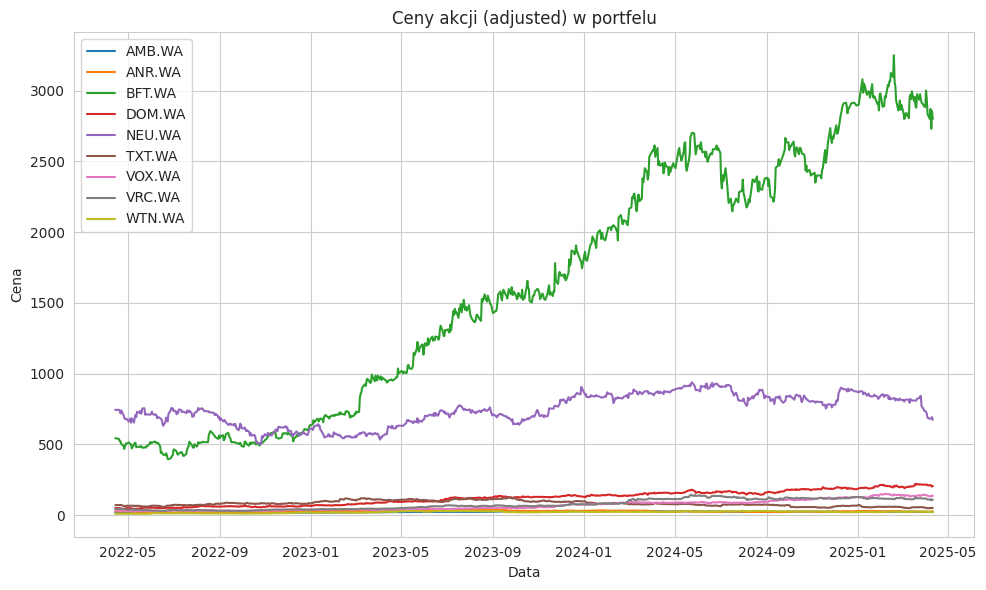

In [18]:
plt.figure(figsize=(10,6))
for col in df_adj_close.columns:
    plt.plot(df_adj_close.index, df_adj_close[col], label=col)
plt.title("Ceny akcji (adjusted) w portfelu")
plt.xlabel("Data")
plt.ylabel("Cena")
plt.legend()
plt.tight_layout()
plt.show()

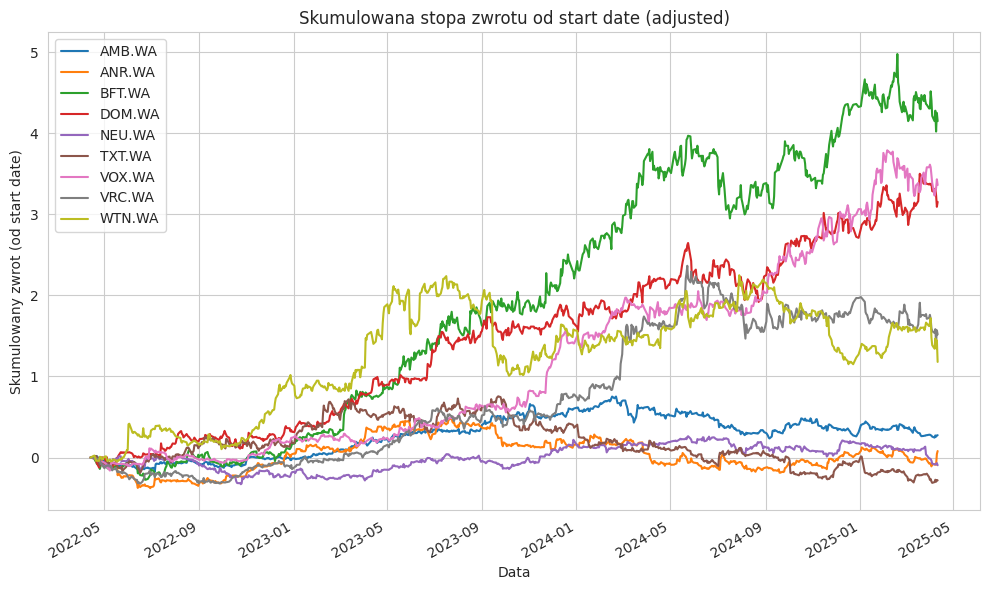

In [19]:
# Obliczamy skumulowaną stopę zwrotu od pierwszego dnia
cumulative_returns_df = (df_adj_close / df_adj_close.iloc[0]) - 1

plt.figure(figsize=(10,6))
cumulative_returns_df.plot(ax=plt.gca())

plt.title("Skumulowana stopa zwrotu od start date (adjusted)")
plt.xlabel("Data")
plt.ylabel("Skumulowany zwrot (od start date)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


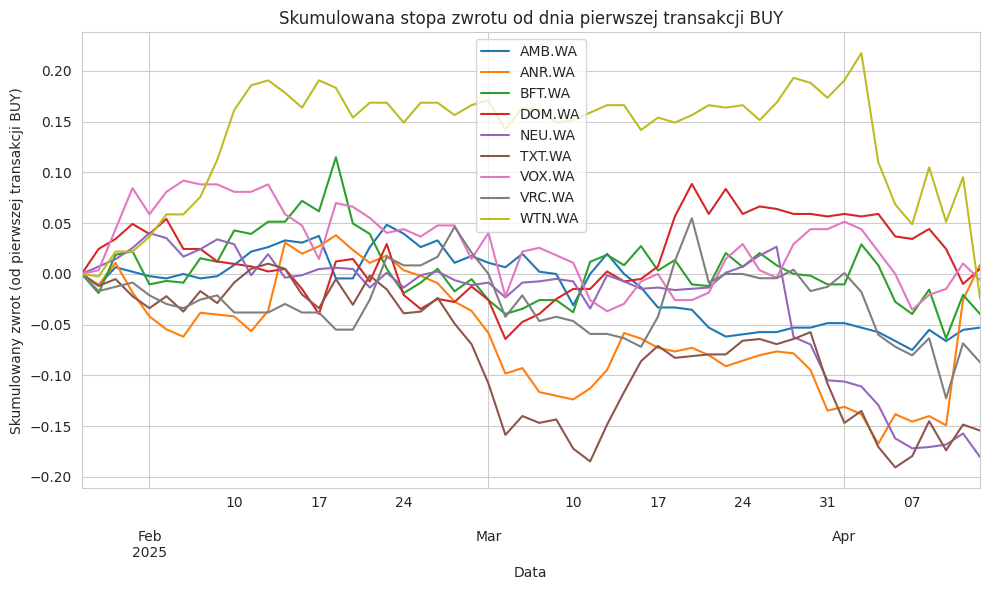

In [20]:
# Skumulowana stopa zwrotu spółek od dnia pierwszej transakcji BUY
first_buy_date = df_tx.loc[df_tx["Czynność"] == "BUY", "Data"].min()

cumulative_returns_from_buy = (df_adj_close.loc[first_buy_date:] / df_adj_close.loc[first_buy_date]) - 1

plt.figure(figsize=(10, 6))
cumulative_returns_from_buy.plot(ax=plt.gca())

plt.title("Skumulowana stopa zwrotu od dnia pierwszej transakcji BUY")
plt.xlabel("Data")
plt.ylabel("Skumulowany zwrot (od pierwszej transakcji BUY)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


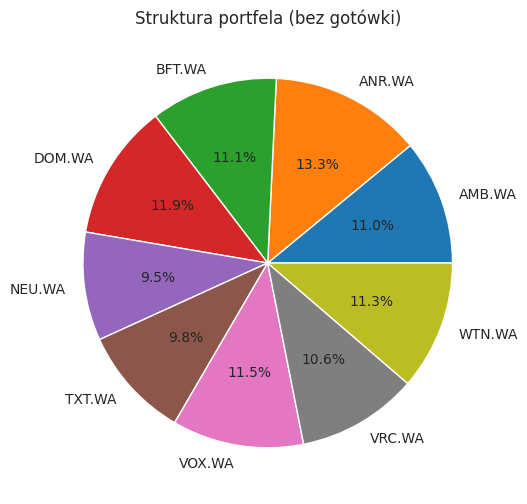

In [21]:
df_stocks_only = df_portfolio.drop("GOTÓWKA", errors="ignore")
plt.figure(figsize=(6,6))
plt.pie(df_stocks_only["Wartość"], labels=df_stocks_only.index, autopct="%1.1f%%")
plt.title("Struktura portfela (bez gotówki)")
plt.show()

## Funkcje wskaźników ryzyka

In [39]:
# Tworzymy funkcje dla wskaźników ryzyka
def calculate_var(series, confidence=0.95):
    """
    Przyjmujemy, że VaR na poziomie 95% to 5-ty percentyl strat (negatywne zwroty)
    """
    return np.percentile(series, (1 - confidence) * 100)

def calculate_cvar(series, confidence=0.95):
    var = calculate_var(series, confidence)
    return series[series <= var].mean()

def max_drawdown(returns: pd.Series) -> float:
    """
    Oblicza maksymalne obsunięcie kapitału przy użyciu prostych stóp zwrotu.
    Zwraca wartość w przedziale [-1, 0], np. -0.30 oznacza -30%.
    """
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max) - 1.0
    mdd_fraction = drawdown.min()
    return mdd_fraction

def beta(portfolio_returns: pd.Series, benchmark_returns: pd.Series) -> float:
    """
    Liczy Betę portfela względem benchmarku:
    Beta = Cov(Rp, Rb) / Var(Rb).
    """
    df_temp = pd.DataFrame({
        "Rp": portfolio_returns,
        "Rb": benchmark_returns
    }).dropna()

    cov = np.cov(df_temp["Rp"], df_temp["Rb"])[0,1]
    var_bench = np.var(df_temp["Rb"])
    if var_bench == 0:
        return np.nan
    return cov / var_bench

    print(portfolio_returns.head())

# Nowa sekcja

Funkcja wskaźników

In [25]:
def sharpe_ratio(portfolio_returns, risk_free_rate, periods_per_year=252):
    excess = portfolio_returns - (risk_free_rate / periods_per_year)
    return excess.mean() / excess.std()

def treynor_ratio(portfolio_returns, benchmark_returns, risk_free_rate, periods_per_year=252):
    beta_val = beta(portfolio_returns, benchmark_returns)
    if beta_val == 0:
        return np.nan
    excess = portfolio_returns - (risk_free_rate / periods_per_year)
    return excess.mean() / beta_val

def jensen_alpha(portfolio_returns, benchmark_returns, risk_free_rate, periods_per_year=252):
    beta_val = beta(portfolio_returns, benchmark_returns)
    excess_p = portfolio_returns.mean() - (risk_free_rate / periods_per_year)
    excess_b = benchmark_returns.mean() - (risk_free_rate / periods_per_year)
    return excess_p - beta_val * excess_b

def modigliani_modigliani(portfolio_returns, benchmark_returns, risk_free_rate, periods_per_year=252):
    sharpe = sharpe_ratio(portfolio_returns, risk_free_rate, periods_per_year)
    return risk_free_rate + sharpe * benchmark_returns.std() * np.sqrt(periods_per_year)


Wskaźniki portfela

In [24]:
#WPROWADZIĆ RISK FREE RATE
risk_free_rate = 0.5244  # 5.244% rocznie, przed runowaniem kodu sprawdzić: https://www.tradingview.com/chart/cl2E2ZOg/?symbol=TVC%3APL10Y
periods_per_year = 252    # Liczba sesji giełdowych w roku

# Zakładamy, że df_adj_close zawiera skorygowane ceny
# Liczymy dzienne stopy zwrotu
returns = df_adj_close.pct_change().dropna()

# Portfel równoważony (np. średnia zwrotów)
portfolio_returns = returns.mean(axis=1)

# Pobierz benchmark, np. S&P 500
benchmark = yf.download("^GSPC", start=start_date, end=end_date)["Adj Close"]
benchmark.index = benchmark.index.tz_localize(None)
benchmark_returns = benchmark.pct_change().dropna()

# Dopasuj indeksy (na wszelki wypadek)
aligned = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
portfolio_returns = aligned.iloc[:, 0]
benchmark_returns = aligned.iloc[:, 1]

# Obliczenia
print("Sharpe:", sharpe_ratio(portfolio_returns, risk_free_rate))
print("Treynor:", treynor_ratio(portfolio_returns, benchmark_returns, risk_free_rate))
print("Jensen's Alpha:", jensen_alpha(portfolio_returns, benchmark_returns, risk_free_rate))
print("Modigliani-Modigliani:", modigliani_modigliani(portfolio_returns, benchmark_returns, risk_free_rate))


[*********************100%***********************]  1 of 1 completed


KeyError: 'Adj Close'

## Benchmark

In [36]:
#df_mwig = pd.read_csv("/Users/korneliakozaczewska/Desktop/mwig40tr_d.csv", sep=",", parse_dates=["Data"], dayfirst=False)
#df_swig = pd.read_csv("/Users/korneliakozaczewska/Desktop/swig80tr_d.csv", sep=",", parse_dates=["Data"], dayfirst=False)

# Obliczamy proste stopy zwrotu
# Konwersja wartości zamknięcia na liczby
df_mwig["Zamkniecie"] = pd.to_numeric(df_mwig["Zamkniecie"], errors="coerce")
df_swig["Zamkniecie"] = pd.to_numeric(df_swig["Zamkniecie"], errors="coerce")

# Obliczamy proste stopy zwrotu
df_mwig["mwig_ret"] = df_mwig["Zamkniecie"].pct_change()
df_swig["swig_ret"] = df_swig["Zamkniecie"].pct_change()


# Łączymy w całość
df_bench = pd.merge(df_mwig, df_swig, on="Data", how="inner").sort_values("Data")
df_bench["benchmark_ret"] = 0.2 * df_bench["mwig_ret"] + 0.8 * df_bench["swig_ret"]

benchmark_returns = df_bench.set_index("Data")["benchmark_ret"].dropna()

print(benchmark_returns.head())

Data
2010-01-04    0.014623
2010-01-05    0.005169
2010-01-06    0.005420
2010-01-07   -0.005134
2010-01-08    0.005675
Name: benchmark_ret, dtype: float64


## Ryzyko spółek

In [37]:
# Obliczamy dzienne stopy zwrotu z danych historycznych
returns = (df_adj_close / df_adj_close.shift(1) - 1).dropna()

# Liczymy wskaźniki ryzyka dla kazdej spółki
risk_metrics = {}
for ticker in returns.columns:
    ticker_returns = returns[ticker]

    volatility = ticker_returns.std()
    var_95 = calculate_var(ticker_returns, confidence=0.95)
    cvar_95 = calculate_cvar(ticker_returns, confidence=0.95)

    beta_ticker = beta(ticker_returns, benchmark_returns)
    max_dd = max_drawdown(ticker_returns)

    risk_metrics[ticker] = {"Volatility": volatility, "VaR (95%)": var_95, "CVaR (95%)": cvar_95, "Beta": beta_ticker, "Max Drawdown": max_dd}

risk_df = pd.DataFrame(risk_metrics).T
print(risk_df)

        Volatility  VaR (95%)  CVaR (95%)  Beta  Max Drawdown
AMB.WA    0.016406  -0.023689   -0.033725   NaN     -0.295031
ANR.WA    0.023951  -0.032596   -0.050421   NaN     -0.451444
BFT.WA    0.025802  -0.033515   -0.048573   NaN     -0.265079
DOM.WA    0.020873  -0.028427   -0.039726   NaN     -0.199408
NEU.WA    0.019892  -0.030070   -0.042759   NaN     -0.341584
TXT.WA    0.026873  -0.038341   -0.057380   NaN     -0.608232
VOX.WA    0.019176  -0.025891   -0.035872   NaN     -0.159899
VRC.WA    0.023642  -0.035183   -0.048985   NaN     -0.320088
WTN.WA    0.027966  -0.034382   -0.054671   NaN     -0.379947


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
<ipython-input-30-a373a4e7fda0>:33: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(df_temp["Rp"], df_temp["Rb"])[0,1]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:130: RuntimeWarning: inval

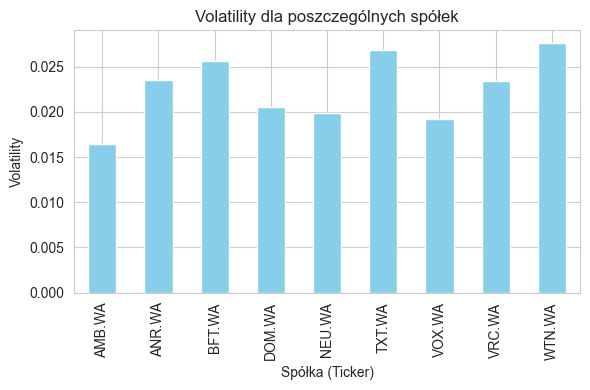

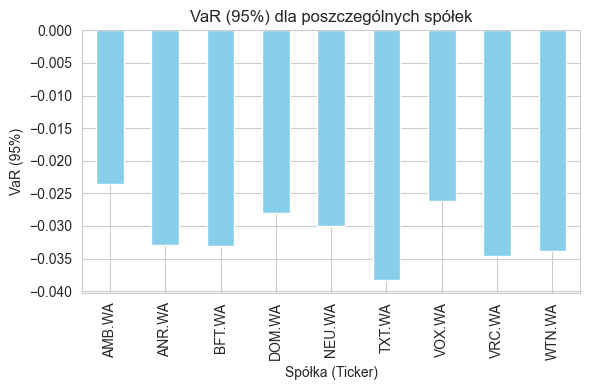

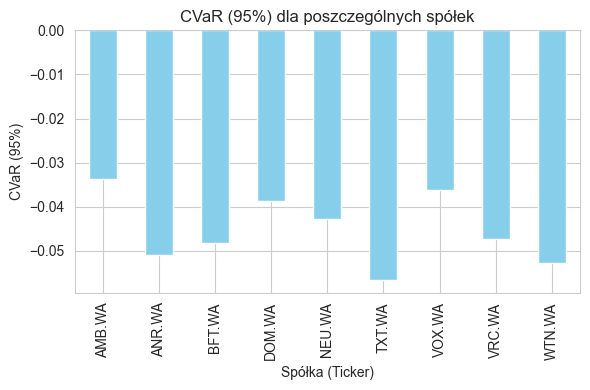

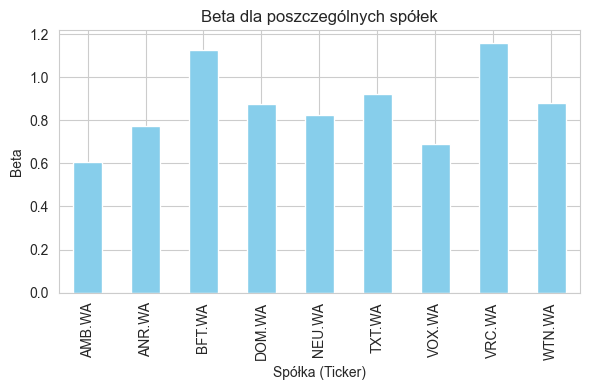

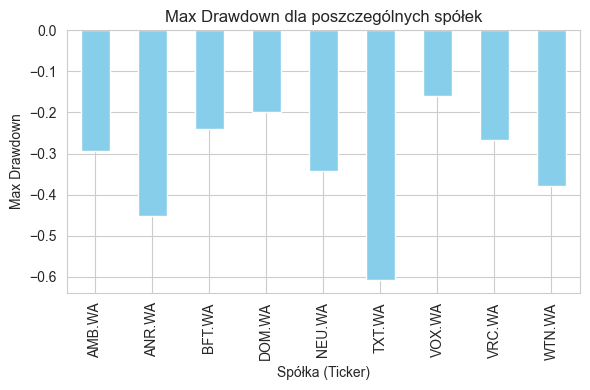

In [ ]:
risk_columns = ["Volatility", "VaR (95%)", "CVaR (95%)", "Beta", "Max Drawdown"]

for col in risk_columns:
    df_plot = risk_df[[col]].dropna()

    plt.figure(figsize=(6,4))
    df_plot.plot(kind="bar", legend=False, ax=plt.gca(), color="skyblue")
    plt.title(f"{col} dla poszczególnych spółek")
    plt.xlabel("Spółka (Ticker)")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


## Ryzyko portfela

In [42]:
# Obliczamy dzienne zwroty portfela jako średnią wazoną (wartością w portfelu) zwrotów poszczególnych spółek (bez gotówki)
df_stocks = df_portfolio.drop("GOTÓWKA", errors="ignore")
stock_weights = df_stocks["Wartość"] / df_stocks["Wartość"].sum()
portfolio_returns = (returns * stock_weights).sum(axis=1)

port_volatility = portfolio_returns.std()
port_var_95 = np.percentile(portfolio_returns, 5)
port_cvar_95 = portfolio_returns[portfolio_returns <= port_var_95].mean()

port_beta = beta(portfolio_returns, benchmark_returns)
port_max_dd = max_drawdown(portfolio_returns)

portfolio_risk = pd.DataFrame({
    "Volatility": [port_volatility],
    "VaR (95%)": [port_var_95],
    "CVaR (95%)": [port_cvar_95],
    "Beta": [port_beta],
    "Max Drawdown": [port_max_dd]
}, index=["Portfel"])

print("\nWskaźniki ryzyka dla portfela:")

KeyError: 'Wartość'

In [46]:
pip install ecos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 3.5 MB/s eta 0:00:00


## Optymalizacja (korzystamy z pliku portfolio2 - wycenione) z kwadratami wag

In [51]:
#file_path = "/Users/korneliakozaczewska/Desktop/portfolio2.xlsx"
#df_pf = pd.read_excel(file_path, dtype=str)

# Ściąganie danych
if "Cena docelowa" in df_pf.columns:

# Jeśli są przecinki, najpierw rzutujemy na string, potem na float
  df_pf["Cena docelowa"] = df_pf["Cena docelowa"].astype(str).str.replace(",", ".", regex=False)
  df_pf["Cena docelowa"] = pd.to_numeric(df_pf["Cena docelowa"], errors="coerce")

else:
    print("Brak Cena docelowa")

if "Sektor" not in df_pf.columns: print("Brak Sektor")

if "Ticker" in df_pf.columns:
    df_pf["Ticker"] = (
        df_pf["Ticker"]
        .astype(str)
        .apply(lambda x: x.replace("WSE:", "") + ".WA" if x else x)
    )
else:
    print("Brak Ticker")

df_pf = df_pf.set_index(df_pf["Ticker"])


# Ograniczenia i parametry
n_assets = len(df_pf["Ticker"])
max_assets = 5
min_weight = 0.05
max_sector_weight = 0.5
max_weight_square_sum = 0.25
#odchylenie standardowe portfela

# Dane
tickers_wycenione = df_pf["Ticker"]
valuation = df_pf["Cena docelowa"]
price = df_pf["Ticker"].map(last_prices)
volatility = df_pf["Ticker"].map(risk_df["Volatility"])
score = (valuation - price) / volatility
sectors = df_pf["Sektor"]
#odchylenie standasrdowe portfela z 3 lat

dane = pd.DataFrame({
    "Sector": sectors,
    "Wycena": valuation,
    "Cena": price,
    "Zmienność": volatility,
    "Score": score,
}, index=tickers_wycenione)
display(dane)

# Zmienne decyzyjne
w = cp.Variable(n_assets)
z = cp.Variable(n_assets, boolean=True)

# Ograniczenia
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= z,
    cp.sum(z) <= max_assets,
    cp.sum_squares(w) <= max_weight_square_sum
]

for i in range(n_assets):
    constraints.append(w[i] >= min_weight * z[i])

for sector in set(sectors):
    idx = [i for i in range(n_assets) if sectors.iloc[i] == sector]
    constraints.append(cp.sum(w[idx]) <= max_sector_weight)

# Funkcja celu
objective = cp.Maximize(score.values @ w)
problem = cp.Problem(objective, constraints)

# Rozwiązanie
!pip install ecos
problem.solve(solver=cp.ECOS_BB)  # bo mamy zmienne binarne

result = problem.solve(solver=cp.ECOS_BB)
print("Status problemu:", problem.status)
print("Optimal value:", problem.value)

# Wyniki
df_wyniki = pd.DataFrame({
    "Waga": np.round(w.value, 4),
    "W portfelu": z.value > 0.5
}, index=tickers_wycenione)

df = pd.concat([dane, df_wyniki], axis=1)
display(df.sort_values(by='Waga', ascending=False))

Sector   Wycena  Cena  Zmienność  Score
Ticker                                                               
DOM.WA.WA.WA             Real Estate   242.29   NaN        NaN    NaN
ANR.WA.WA.WA  Consumer Discretionary    39.80   NaN        NaN    NaN
NEU.WA.WA.WA             Health Care  1066.14   NaN        NaN    NaN
VRC.WA.WA.WA  Information Technology   145.00   NaN        NaN    NaN
WTN.WA.WA.WA  Consumer Discretionary    29.20   NaN        NaN    NaN
TXT.WA.WA.WA  Information Technology    91.75   NaN        NaN    NaN
BFT.WA.WA.WA  Consumer Discretionary  3990.10   NaN        NaN    NaN
AMB.WA.WA.WA        Consumer Staples    31.52   NaN        NaN    NaN
VOX.WA.WA.WA             Health Care   170.00   NaN        NaN    NaN

SolverError: The solver ECOS_BB is not installed.

### 1)  Poprawić model optymalizacyjny + uzupełnić w polityce inwestycyjnej:
1. 12 spółek z upsidem 20%
2. wzór ale przez odchylenie standardowe spółki, porządkujemy od największej i 12 spółek wrzucamy do modelu
3. ten wzór / odch. stand. zmiennych zmian ceny z ostatnich trzech lat z takimi wagami jak w liczniku >>> maksymalnie dla spółki 20%

### 2)  Sprawdzamy ograniczenia bez kwadratów wag
Być może warto zacząć od prostego modelu, a potem stopniowo dodawać kolejne parametry i obserwować, co się dzieje z portfelem.
Alternatywnie można użyć metod scenariuszowych lub stochastycznych (np. generować różne warianty możliwych zmian i szukać portfela, który w miarę dobrze radzi sobie w każdym scenariuszu).

### 3)   Sprawdzamy wrazliwość wag na zmiany w dcf
Może przy tych dcfach spróbujmy zobaczyć po prostu jak się zmieniają wagi portfela, ale pod takim kątem, żeby mały procent zmiany dcf nie zmieniał nam diametralnie wag w portfelu, skoro są one obarczone jakimś błędem. I jeśli zmienia bardzo to będziemy kombinować z ograniczeniami

### 4) Porównać dzienne stopy zwrotu, a tygodniowe stopy zwrotu w odchyleniu standardowym